# Fachprojekt Machine Learning
**Authors:** Anastasiia Korzhylova, Ivan Shishkin, Ramneek Agnihotri, Rodi Mehi

**Due date:** Wednesday, 3. July 2024

## Import necessary components

In [1]:
# Import the necessary libraries
import time, warnings, random
import torch, torch.nn.functional as F
from tabulate import tabulate
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

# Import the VAE model and functions
import networks
from datasets import create_datasets
from evaluation import evaluate
from interpolations import interpolate
from sampling import plot_reconstruction
from plotting import plot_loss_lr, plot_loss_components

## Set hyperparameters, loss function and optimizing tools

In [2]:
# Hyperparameters
batch_size = 128 # Number of images per update of the network
num_epochs = 10 # One epoch means seeing every image of the training dataset
latent_dim = 256  # Size of the latent space
input_channels = 3  # CIFAR-10 images have 3 color channels
learning_rate = 2e-5 # Determines how drastically the parameters of the network change
output_frequency = 150 # Determines how often the training progress will be logged (in batches)
number_embedding_vectors = 100
embedding_dimension = 128
beta = 0.1

# Select the device that will be used for training: GPU, if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('=========================================')

# Put the neural network on the selected device
model = networks.VQVAE(input_channels=input_channels, emb_dim=embedding_dimension, n_embed=number_embedding_vectors, beta=beta)
model.to(device)

# Loss function
def loss_function(recon_x, x, vq_loss):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    return recon_loss + vq_loss, recon_loss, vq_loss

# Optimizer selection
optimizer_option = 'adam'

optimizer = None
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Learning rate scheduler parameters
lr_schedule_option = 'exponential'

scheduler = None
if lr_schedule_option == 'step':
  scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
elif lr_schedule_option == 'exponential':
  scheduler = ExponentialLR(optimizer, gamma=0.9)
elif lr_schedule_option == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# Scaler for AMP
scaler = torch.cuda.amp.GradScaler()

Using device: cuda


## Choose a dataset for training

In [3]:
import torch, itertools
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Resize(64),  # Resize to 64x64
    transforms.CenterCrop(64),  # Crop to 64x64 at center
    transforms.ToTensor(),  # Convert to tensor
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

#batch_size = 128

train_dataset = datasets.CelebA(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
# Create and visualize the datasets for MNIST / CIFAR10
#dataset_name = 'MNIST'
#train_loader, test_loader = create_datasets(dataset_name, batch_size)

Files already downloaded and verified


## Training loop

Using device: cuda
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  1/ 10  Batch:    1  Total Loss:  240072  VQ Loss:  0.86608  Recon Loss:  240072  Commitment Loss:  0.787346  Embedding Loss:  0.787346  LR:  2e-05
Epoch:  1/ 10  Batch:  151  Total Loss:  16159.5  VQ Loss:  1.89567  Recon Loss:  16157.6  Commitment Loss:  1.72334  Embedding Loss:  1.72334  LR:  2e-05
Epoch:  1/ 10  Batch:  301  Total Loss:  10375.9  VQ Loss:  1.95971  Recon Loss:  10374  Commitment Loss:  1.78156  Embedding Loss:  1.78156  LR:  2e-05
Epoch:  1/ 10  Batch:  451  Total Loss:  8271.46  VQ Loss:  1.95988  Recon Loss:  8269.5  Commitment Loss:  1.78171  Embedding Loss:  1.78171  LR:  2e-05
Epoch:  1/ 10  Batch:  601  Total Loss:  5715.79  VQ Loss:  1.97379  Recon Loss:  5713.82  Commitment Loss:  1.79435  Embedding Loss:  1.79435  LR:  2e-05
Epoch:  1/ 10  Batch:  751  Total Loss:  5005.93  VQ Loss:  1.96591  Recon Loss:  5

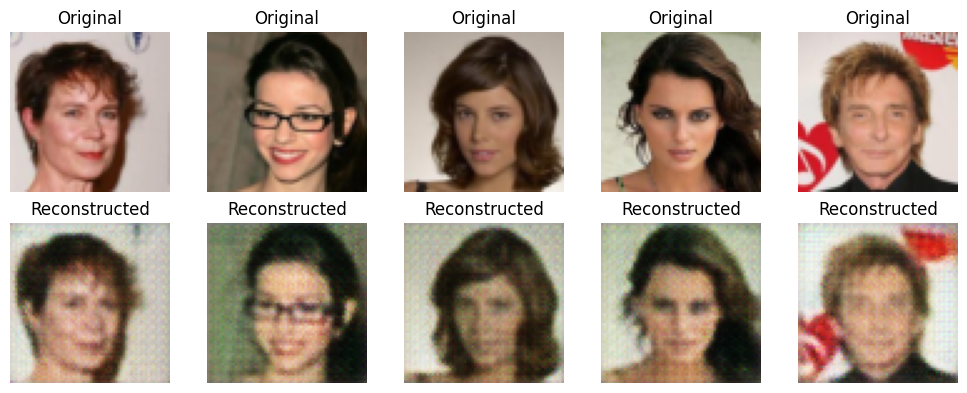

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  2/ 10  Batch:    1  Total Loss:  3372.68  VQ Loss:  2.20961  Recon Loss:  3370.47  Commitment Loss:  2.00874  Embedding Loss:  2.00874  LR:  1.8e-05
Epoch:  2/ 10  Batch:  151  Total Loss:  3235.9  VQ Loss:  2.17663  Recon Loss:  3233.72  Commitment Loss:  1.97875  Embedding Loss:  1.97875  LR:  1.8e-05
Epoch:  2/ 10  Batch:  301  Total Loss:  2852.24  VQ Loss:  2.20977  Recon Loss:  2850.03  Commitment Loss:  2.00888  Embedding Loss:  2.00888  LR:  1.8e-05
Epoch:  2/ 10  Batch:  451  Total Loss:  3243  VQ Loss:  2.21432  Recon Loss:  3240.79  Commitment Loss:  2.01302  Embedding Loss:  2.01302  LR:  1.8e-05
Epoch:  2/ 10  Batch:  601  Total Loss:  2766.93  VQ Loss:  2.18999  Recon Loss:  2764.74  Commitment Loss:  1.9909  Embeddi

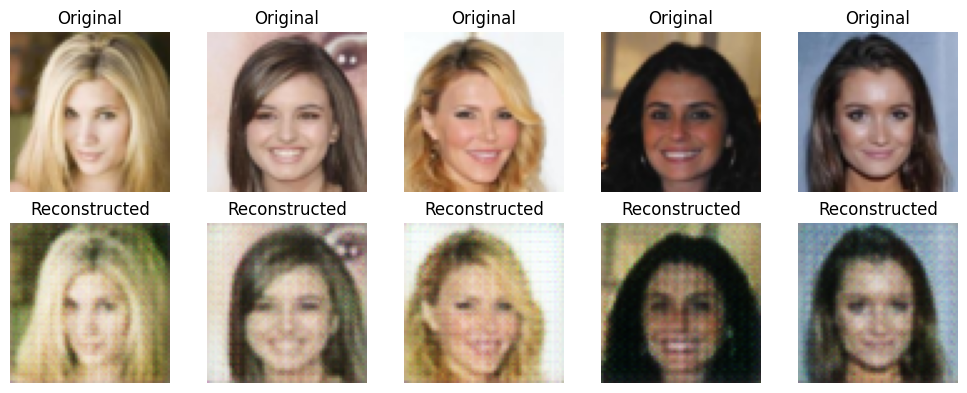

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  3/ 10  Batch:    1  Total Loss:  2245.81  VQ Loss:  2.09594  Recon Loss:  2243.72  Commitment Loss:  1.9054  Embedding Loss:  1.9054  LR:  1.62e-05
Epoch:  3/ 10  Batch:  151  Total Loss:  2204.39  VQ Loss:  2.27034  Recon Loss:  2202.12  Commitment Loss:  2.06394  Embedding Loss:  2.06394  LR:  1.62e-05
Epoch:  3/ 10  Batch:  301  Total Loss:  2062.92  VQ Loss:  2.26014  Recon Loss:  2060.66  Commitment Loss:  2.05467  Embedding Loss:  2.05467  LR:  1.62e-05
Epoch:  3/ 10  Batch:  451  Total Loss:  1719.09  VQ Loss:  2.17324  Recon Loss:  1716.92  Commitment Loss:  1.97567  Embedding Loss:  1.97567  LR:  1.62e-05
Epoch:  3/ 10  Batch:  601  Total Loss:  1871.17  VQ Loss:  2.09526  Recon Loss:  1869.07  Commitment Loss:  1.90478  

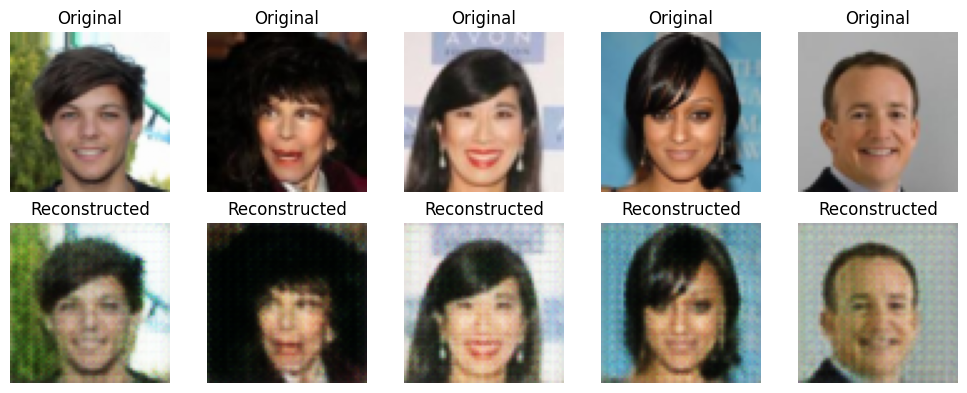

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  4/ 10  Batch:    1  Total Loss:  1780.25  VQ Loss:  2.11219  Recon Loss:  1778.14  Commitment Loss:  1.92018  Embedding Loss:  1.92018  LR:  1.458e-05
Epoch:  4/ 10  Batch:  151  Total Loss:  1604.73  VQ Loss:  2.04631  Recon Loss:  1602.68  Commitment Loss:  1.86028  Embedding Loss:  1.86028  LR:  1.458e-05
Epoch:  4/ 10  Batch:  301  Total Loss:  1480.37  VQ Loss:  2.06915  Recon Loss:  1478.3  Commitment Loss:  1.88105  Embedding Loss:  1.88105  LR:  1.458e-05
Epoch:  4/ 10  Batch:  451  Total Loss:  1455.16  VQ Loss:  2.01536  Recon Loss:  1453.15  Commitment Loss:  1.83215  Embedding Loss:  1.83215  LR:  1.458e-05
Epoch:  4/ 10  Batch:  601  Total Loss:  1668.31  VQ Loss:  1.97583  Recon Loss:  1666.34  Commitment Loss:  1.79

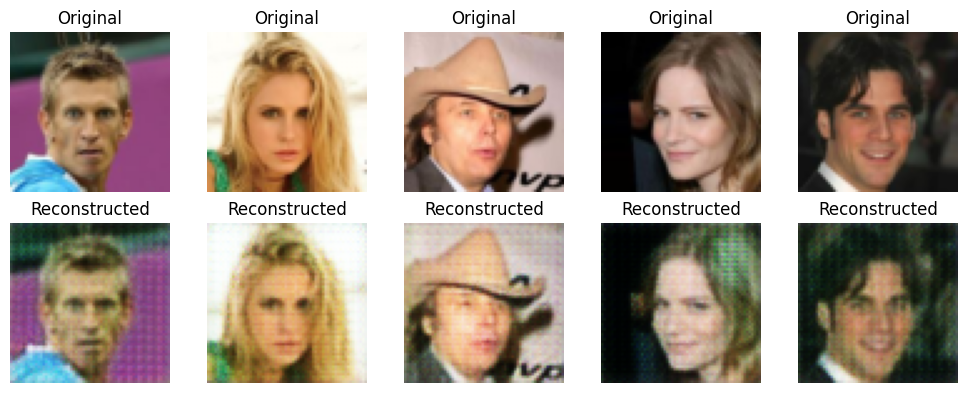

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  5/ 10  Batch:    1  Total Loss:  1368.64  VQ Loss:  1.98628  Recon Loss:  1366.66  Commitment Loss:  1.80571  Embedding Loss:  1.80571  LR:  1.3122e-05
Epoch:  5/ 10  Batch:  151  Total Loss:  1651.71  VQ Loss:  1.93066  Recon Loss:  1649.78  Commitment Loss:  1.75514  Embedding Loss:  1.75514  LR:  1.3122e-05
Epoch:  5/ 10  Batch:  301  Total Loss:  1372.69  VQ Loss:  1.92276  Recon Loss:  1370.77  Commitment Loss:  1.74796  Embedding Loss:  1.74796  LR:  1.3122e-05
Epoch:  5/ 10  Batch:  451  Total Loss:  1299.24  VQ Loss:  1.97141  Recon Loss:  1297.27  Commitment Loss:  1.79219  Embedding Loss:  1.79219  LR:  1.3122e-05
Epoch:  5/ 10  Batch:  601  Total Loss:  1325.69  VQ Loss:  1.9791  Recon Loss:  1323.71  Commitment Loss:  

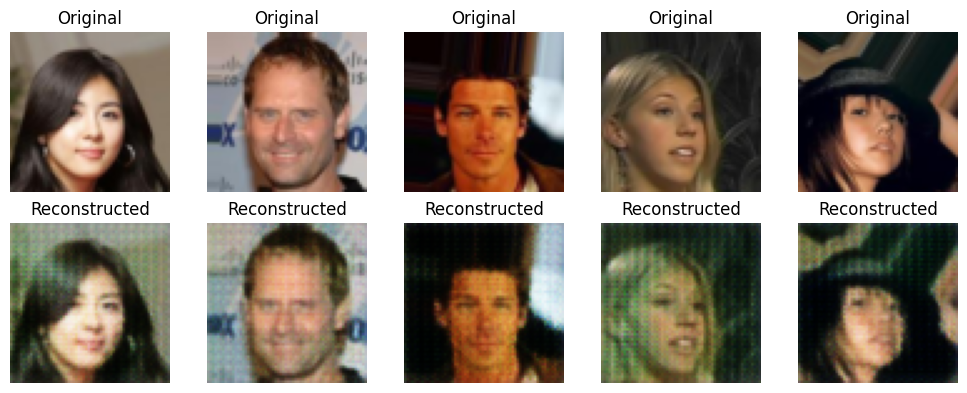

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  6/ 10  Batch:    1  Total Loss:  1312.25  VQ Loss:  1.98215  Recon Loss:  1310.26  Commitment Loss:  1.80196  Embedding Loss:  1.80196  LR:  1.18098e-05
Epoch:  6/ 10  Batch:  151  Total Loss:  1116.67  VQ Loss:  1.88441  Recon Loss:  1114.78  Commitment Loss:  1.71311  Embedding Loss:  1.71311  LR:  1.18098e-05
Epoch:  6/ 10  Batch:  301  Total Loss:  1217.77  VQ Loss:  1.98014  Recon Loss:  1215.79  Commitment Loss:  1.80013  Embedding Loss:  1.80013  LR:  1.18098e-05
Epoch:  6/ 10  Batch:  451  Total Loss:  1163.86  VQ Loss:  1.94441  Recon Loss:  1161.92  Commitment Loss:  1.76764  Embedding Loss:  1.76764  LR:  1.18098e-05
Epoch:  6/ 10  Batch:  601  Total Loss:  1094.05  VQ Loss:  1.88587  Recon Loss:  1092.17  Commitment Lo

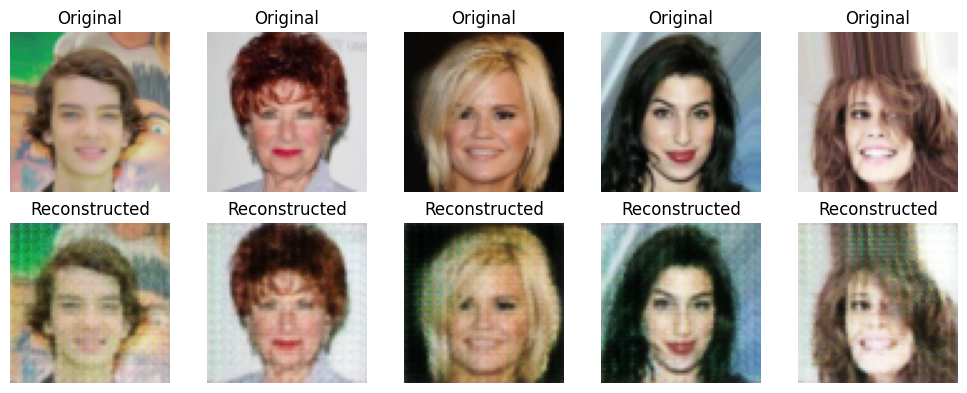

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  7/ 10  Batch:    1  Total Loss:  1303.75  VQ Loss:  1.94846  Recon Loss:  1301.8  Commitment Loss:  1.77133  Embedding Loss:  1.77133  LR:  1.06288e-05
Epoch:  7/ 10  Batch:  151  Total Loss:  973.927  VQ Loss:  1.85327  Recon Loss:  972.074  Commitment Loss:  1.6848  Embedding Loss:  1.6848  LR:  1.06288e-05
Epoch:  7/ 10  Batch:  301  Total Loss:  1038.93  VQ Loss:  1.87094  Recon Loss:  1037.06  Commitment Loss:  1.70085  Embedding Loss:  1.70085  LR:  1.06288e-05
Epoch:  7/ 10  Batch:  451  Total Loss:  1081.96  VQ Loss:  1.89074  Recon Loss:  1080.07  Commitment Loss:  1.71885  Embedding Loss:  1.71885  LR:  1.06288e-05
Epoch:  7/ 10  Batch:  601  Total Loss:  1122.34  VQ Loss:  1.83081  Recon Loss:  1120.5  Commitment Loss: 

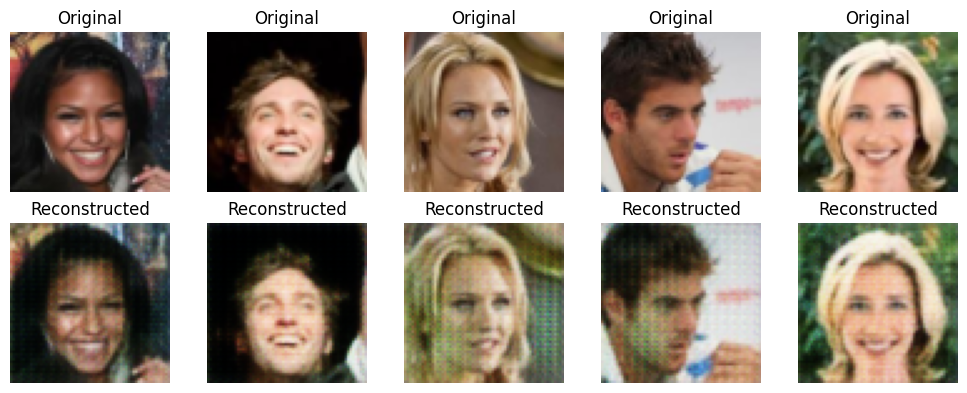

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  8/ 10  Batch:    1  Total Loss:  972.833  VQ Loss:  1.81586  Recon Loss:  971.017  Commitment Loss:  1.65078  Embedding Loss:  1.65078  LR:  9.56594e-06
Epoch:  8/ 10  Batch:  151  Total Loss:  1015.36  VQ Loss:  1.84214  Recon Loss:  1013.52  Commitment Loss:  1.67468  Embedding Loss:  1.67468  LR:  9.56594e-06
Epoch:  8/ 10  Batch:  301  Total Loss:  981.393  VQ Loss:  1.78526  Recon Loss:  979.608  Commitment Loss:  1.62296  Embedding Loss:  1.62296  LR:  9.56594e-06
Epoch:  8/ 10  Batch:  451  Total Loss:  938.89  VQ Loss:  1.79197  Recon Loss:  937.098  Commitment Loss:  1.62906  Embedding Loss:  1.62906  LR:  9.56594e-06
Epoch:  8/ 10  Batch:  601  Total Loss:  1031.19  VQ Loss:  1.80177  Recon Loss:  1029.39  Commitment Los

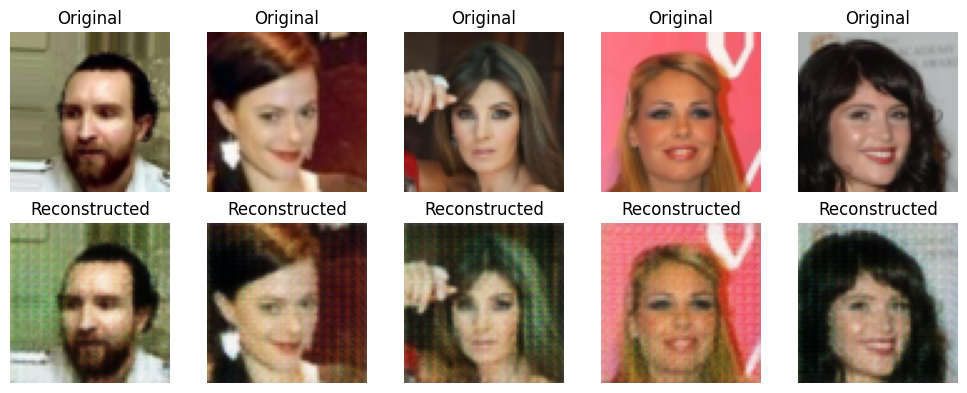

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  9/ 10  Batch:    1  Total Loss:  892.947  VQ Loss:  1.84378  Recon Loss:  891.103  Commitment Loss:  1.67616  Embedding Loss:  1.67616  LR:  8.60934e-06
Epoch:  9/ 10  Batch:  151  Total Loss:  847.03  VQ Loss:  1.79736  Recon Loss:  845.232  Commitment Loss:  1.63396  Embedding Loss:  1.63396  LR:  8.60934e-06
Epoch:  9/ 10  Batch:  301  Total Loss:  958.909  VQ Loss:  1.78219  Recon Loss:  957.127  Commitment Loss:  1.62017  Embedding Loss:  1.62017  LR:  8.60934e-06
Epoch:  9/ 10  Batch:  451  Total Loss:  994.445  VQ Loss:  1.86528  Recon Loss:  992.58  Commitment Loss:  1.69571  Embedding Loss:  1.69571  LR:  8.60934e-06
Epoch:  9/ 10  Batch:  601  Total Loss:  808.567  VQ Loss:  1.80751  Recon Loss:  806.76  Commitment Loss:

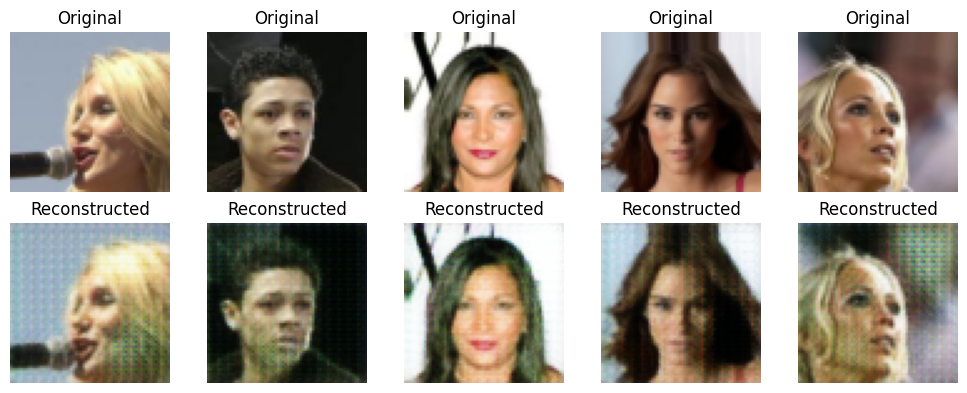

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  10/ 10  Batch:    1  Total Loss:  818.161  VQ Loss:  1.75485  Recon Loss:  816.407  Commitment Loss:  1.59532  Embedding Loss:  1.59532  LR:  7.74841e-06
Epoch:  10/ 10  Batch:  151  Total Loss:  831.953  VQ Loss:  1.79697  Recon Loss:  830.156  Commitment Loss:  1.63361  Embedding Loss:  1.63361  LR:  7.74841e-06
Epoch:  10/ 10  Batch:  301  Total Loss:  808.799  VQ Loss:  1.72494  Recon Loss:  807.075  Commitment Loss:  1.56813  Embedding Loss:  1.56813  LR:  7.74841e-06
Epoch:  10/ 10  Batch:  451  Total Loss:  806.734  VQ Loss:  1.78415  Recon Loss:  804.949  Commitment Loss:  1.62196  Embedding Loss:  1.62196  LR:  7.74841e-06
Epoch:  10/ 10  Batch:  601  Total Loss:  747.082  VQ Loss:  1.7225  Recon Loss:  745.359  Commitmen

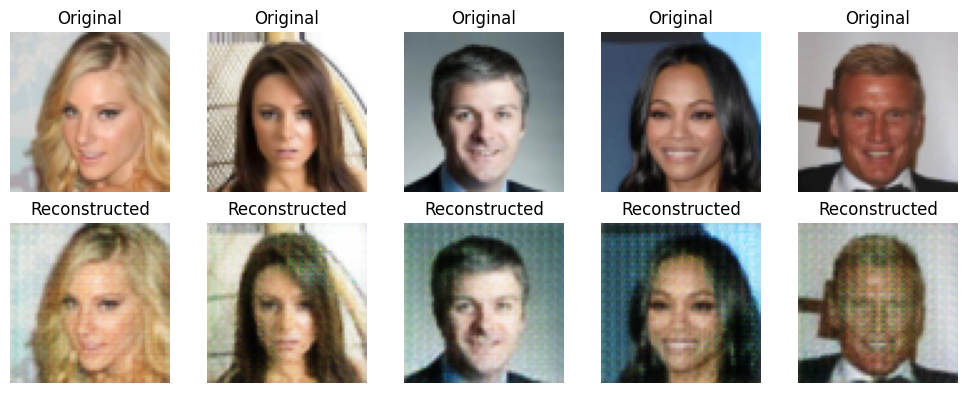

-----------------------------------------------------------------------------------------------------------------------------


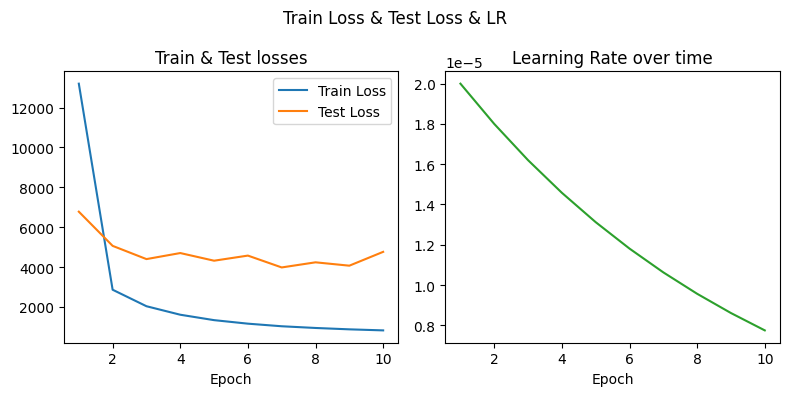

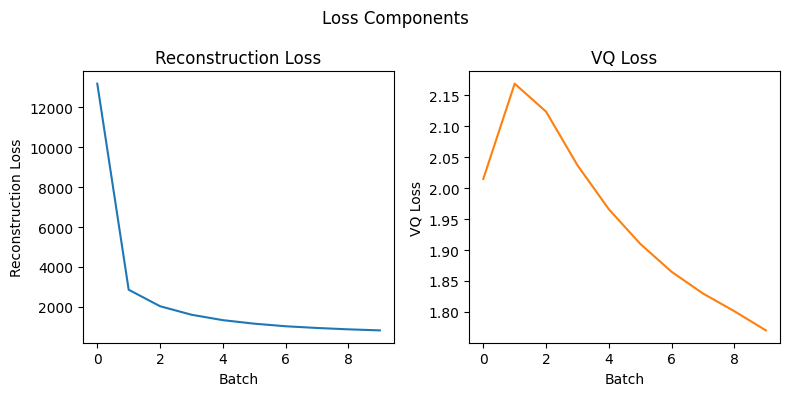

In [4]:
# Suppress user warnings
warnings.filterwarnings("ignore")
print(f'Using device: {device}')
print('=========================================')
# Initialize lists for tracking losses and learning rates
train_losses = []
test_losses = []
learning_rates = []
reconstruction_losses = []
vq_losses = []
commitment_losses = []
embedding_losses = []

# Training loop
for epoch in range(num_epochs):
    print('-----------------------------------------------------------------------------------------------------------------------------')
    model.train()

    batch_recon_losses = []
    batch_vq_losses = []
    batch_total_losses = []

    epoch_start_time = time.time()  # Start of time measurement

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            # Forward pass
            recon_batch, vqloss, embedding_loss, commitment_loss = model(data)

            # Compute loss
            loss, recon_loss, _  = loss_function(recon_batch, data, vqloss)

        # Backward pass
        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        # Save the loss values for the current batch
        curr_loss = loss.detach().item()
        curr_vqloss = vqloss.detach().item()
        curr_recon_loss = recon_loss.detach().item()
        curr_commitment_loss = commitment_loss.detach().item()
        curr_embedding_loss = embedding_loss.detach().item()
        batch_total_losses.append(curr_loss)
        batch_vq_losses.append(curr_vqloss)
        batch_recon_losses.append(curr_recon_loss)

        # Log training loss and current learning rate
        if batch_idx % output_frequency == 0:
            log = [['Epoch:', f'{epoch + 1:3d}/{num_epochs:3d}', 'Batch:', f'{batch_idx + 1:3d}',
                    'Total Loss:', f'{curr_loss:.6f}', 'VQ Loss:', f'{curr_vqloss:.6f}',
                    'Recon Loss:', f'{curr_recon_loss:.6f}',
                    'Commitment Loss:', f'{curr_commitment_loss:.6f}',
                    'Embedding Loss:', f'{curr_embedding_loss:.6f}',
                    'LR:', scheduler.get_last_lr()[0]]]
            print(tabulate(log, tablefmt="plain"))

    # Step the learning rate scheduler
    if scheduler is not None:
        lr = scheduler.get_last_lr()[0]
        scheduler.step()
    else:
        lr = learning_rate
    learning_rates.append(lr)

    # After the epoch, evaluate the accuracy on the test dataset
    mean_loss = evaluate(model, train_loader, loss_function, device)
    test_losses.append(mean_loss)

    # Save the average loss values
    average_total_loss = torch.tensor(batch_total_losses).mean().item()
    average_recon_loss = torch.tensor(batch_recon_losses).mean().item()
    average_vq_loss = torch.tensor(batch_vq_losses).mean().item()

    train_losses.append(average_total_loss)
    reconstruction_losses.append(average_recon_loss)
    vq_losses.append(average_vq_loss)

    # End of time measurement
    elapsed_time = time.time() - epoch_start_time

    # Log epoch results
    headers = ["Epoch", "Mean Test Loss", "Time"]
    data = [[epoch + 1, f"{mean_loss:.4f}", f"{elapsed_time:.2f}s"]]
    print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

    # Generate reconstructed test images after each epoch
    plot_reconstruction(model, train_loader, device, num_samples=5)
    print('-----------------------------------------------------------------------------------------------------------------------------')

# Plot Train Loss & Test Loss & LR
plot_loss_lr(num_epochs, train_losses, test_losses, learning_rates)

# Plot each loss component
plot_loss_components(reconstruction_losses, vq_losses)


In [6]:
# Create a video  of images that show the interpolation on a linear trajectory between z1 and z2
images, _ = next(iter(train_loader))
z1 = model.vectorquantizer(model.encoder(random.choice(images).to(device).unsqueeze(0)))[0]
z2 = model.vectorquantizer(model.encoder(random.choice(images).to(device).unsqueeze(0)))[0]
interpolate(z1, z2, model, steps=30)

Interpolation video saved as output/interpolation.avi.
